In [1]:
import numpy, scipy, matplotlib.pyplot as plt, pandas as pd
import sklearn, IPython.display as ipd, random
import librosa, librosa.display

from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from pathlib import Path
%matplotlib inline

## Step 1: Retrieve Audio

In [2]:
c1_signals = [
    librosa.load(p, duration=30, offset=10)[0] for p in Path().glob('audio/train/c2/*.mp3')
]
c2_signals = [
    librosa.load(p, duration=30, offset=10)[0] for p in Path().glob('audio/train/c3/*.mp3')
]

In [3]:
print(len(c1_signals))
print(len(c2_signals))

100
100


## Step 2: Extract Features

In [4]:
n_mfcc = 12
hop_length = 512
def extract_features(signal):
    zcr = librosa.feature.zero_crossing_rate(signal).mean()
    cent = librosa.feature.spectral_centroid(signal).mean()
    mfccs = librosa.feature.mfcc(signal, n_mfcc=n_mfcc).mean()
    S = librosa.feature.melspectrogram(signal).mean()
    tempo = librosa.feature.tempogram(signal, hop_length=hop_length).mean()
    rmse = librosa.feature.rmse(signal, hop_length=hop_length).mean()
    chroma = librosa.feature.chroma_stft(signal).mean()
    spec_bw = librosa.feature.spectral_bandwidth(signal).mean()
    return [zcr, cent, mfccs, S, tempo, rmse, chroma, spec_bw]

In [5]:
c1_features = numpy.array([extract_features(x) for x in c1_signals])
c2_features = numpy.array([extract_features(x) for x in c2_signals])

/home/kameswar/anaconda3/lib/python3.6/site-packages/librosa/core/audio.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad((y_sign[slice_post] != y_sign[slice_pre]),
/home/kameswar/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1377: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_agg[idx_agg] = aggregate(data[idx_in], axis=axis)
/home/kameswar/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tu

In [6]:
print(c1_features.shape)
print(c2_features.shape)

(100, 8)
(100, 8)


## Step 3: Train the Classifier

In [7]:
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))

c1_features_scaled = scaler.fit_transform(c1_features)
print(c1_features_scaled.mean(axis=0))
print(c1_features_scaled.std(axis=0))

c2_features_scaled = scaler.transform(c2_features)
print(c2_features_scaled.mean(axis=0))
print(c2_features_scaled.std(axis=0))

[-0.33847884 -0.22381767  0.25371242 -0.6745272  -0.2419752  -0.31028022
 -0.10791567  0.27149881]
[0.39325175 0.37468819 0.48563564 0.32306946 0.47734233 0.41124464
 0.45644354 0.39070546]
[-0.42205731 -0.31094244  0.43336799 -0.28941244 -0.32654813  0.09204628
 -0.0114468   0.11964931]
[0.32330752 0.30797719 0.49900315 0.6258006  0.49580852 0.55304297
 0.60199185 0.36604784]


In [8]:
train_features = numpy.vstack((c1_features_scaled, c2_features_scaled))
print(train_features.shape)
print(train_features.min(axis=0))
print(train_features.max(axis=0))

(200, 8)
[-1.12155866 -1.0874788  -1.         -1.         -1.13166541 -1.
 -1.09469317 -1.04612388]
[1.         1.         1.20238599 2.01181248 1.05793715 1.58219474
 2.01488172 1.        ]


In [9]:
train_labels = numpy.concatenate((numpy.zeros(len(c1_features_scaled)), numpy.ones(len(c2_features_scaled))))

In [10]:
print(train_labels)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


In [11]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = sklearn.svm.SVC()
model = GridSearchCV(svc, parameters)

In [12]:
#model = sklearn.svm.SVC()

In [13]:
acc  = sklearn.model_selection.cross_val_score(model, train_features, train_labels, cv=10)

In [14]:
print('acc =', acc)
print ('acc mean =',acc.mean())

acc = [0.7  0.85 0.75 0.65 0.6  0.75 0.75 0.7  0.65 0.7 ]
acc mean = 0.7100000000000001


In [15]:
model.fit(train_features, train_labels)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

## Step 4: Run the Classifier

In [16]:
c1_test_signals = [
    librosa.load(p, duration=30, offset=60)[0] for p in Path().glob('audio/test/c2/*.mp3')
]
c2_test_signals = [
    librosa.load(p, duration=30, offset=60)[0] for p in Path().glob('audio/test/c3/*.mp3')
]

In [17]:
print(len(c1_test_signals))
print(len(c2_test_signals))

25
25


In [18]:
c1_test_features = numpy.array([extract_features(x) for x in c1_test_signals])
c2_test_features = numpy.array([extract_features(x) for x in c2_test_signals])

/home/kameswar/anaconda3/lib/python3.6/site-packages/librosa/core/audio.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad((y_sign[slice_post] != y_sign[slice_pre]),
/home/kameswar/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1377: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_agg[idx_agg] = aggregate(data[idx_in], axis=axis)
/home/kameswar/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tu

In [19]:
print(c1_test_features.shape)
print(c2_test_features.shape)

(25, 8)
(25, 8)


In [20]:
c1_test_features_scaled = scaler.transform(c1_test_features)
c2_test_features_scaled = scaler.transform(c2_test_features)

In [21]:
test_features = numpy.vstack((c1_test_features_scaled, c2_test_features_scaled))

In [22]:
test_labels = numpy.concatenate((numpy.zeros(len(c1_test_features)), numpy.ones(len(c2_test_features))))

In [23]:
print(test_labels)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


In [24]:
predicted_labels = model.predict(test_features)

In [25]:
predicted_labels

array([0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Step 5: Evaluation

### Classification Metrics

In [26]:
score = model.score(test_features, test_labels)
accuracy = accuracy_score(test_labels, predicted_labels)
roc_auc = roc_auc_score(test_labels, predicted_labels)
recall = recall_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels)
fmeasure = f1_score(test_labels, predicted_labels)
cohen_kappa = cohen_kappa_score(test_labels, predicted_labels)

In [27]:
tp = sum((test_labels == 1) & (predicted_labels == 1))
tn = sum((test_labels == 0) & (predicted_labels == 0))
fp = sum((test_labels == 0) & (predicted_labels == 1))
fn = sum((test_labels == 1) & (predicted_labels == 0))
print (tp, tn, fp, fn)

24 13 12 1


In [28]:
classification_metrics = [score, accuracy, roc_auc, recall, precision, fmeasure, cohen_kappa]
classification_metrics_labels = ['score', 'accuracy', 'roc_auc', 'recall', 'precision', 'fmeasure', 'cohen_kappa']

In [29]:
pd.DataFrame(classification_metrics, classification_metrics_labels)

,0
score,0.740000
accuracy,0.740000
roc_auc,0.740000
recall,0.960000
precision,0.666667
fmeasure,0.786885
cohen_kappa,0.480000


### Regression Metrics

In [30]:
r2 = r2_score(test_labels, predicted_labels)
explained_variance_score = explained_variance_score(test_labels, predicted_labels)
mean_squared_error = mean_squared_error(test_labels, predicted_labels)

In [31]:
regression_metrics = [r2, explained_variance_score, mean_squared_error]
regression_metrics_labels = ['r2_score', 'explained_variance_score', 'mean_squared_error']

In [32]:
pd.DataFrame(regression_metrics, regression_metrics_labels)

,0
r2_score,-0.0400
explained_variance_score,0.1536
mean_squared_error,0.2600


### Plot ROC Curve

In [33]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, predicted_labels)
roc_auc = auc(false_positive_rate, true_positive_rate)

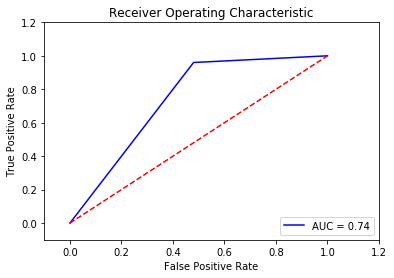

In [34]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()